In [5]:
# import externals libs
import os
import shutil
from scipy.io import  loadmat
import matplotlib.pyplot as plt
# import the needed OGGM modules
import oggm
from oggm import cfg, utils
from oggm.tests.funcs import get_test_dir
from oggm.core import gis, climate, centerlines, vascaling

# create test directory
testdir = os.path.join(get_test_dir(), 'start_area')
if not os.path.exists(testdir):
    os.makedirs(testdir)
shutil.rmtree(testdir)
os.makedirs(testdir)

# load default parameter file
cfg.initialize()
# set path to working directory
cfg.PATHS['working_dir'] = testdir
# load and set path to intersects
path = utils.get_rgi_intersects_region_file('11', version='6')
cfg.set_intersects_db(path)

# change some default parameters
cfg.PARAMS['border'] = 50
cfg.PARAMS['baseline_climate'] = 'CRU'
cfg.PARAMS['use_multiprocessing'] = True

# get RGI entity
rgi_id = 'RGI60-11.00897'
entity = utils.get_rgi_glacier_entities([rgi_id]).iloc[0]

# initialize the GlacierDirectory
gdir = oggm.GlacierDirectory(entity, base_dir=testdir)

# define the local grid and glacier mask
gis.define_glacier_region(gdir, entity=entity)
gis.glacier_masks(gdir)

# process the given climate file
climate.process_cru_data(gdir)

# run center line preprocessing tasks
centerlines.compute_centerlines(gdir)
centerlines.initialize_flowlines(gdir)
centerlines.catchment_area(gdir)
centerlines.catchment_intersections(gdir)
centerlines.catchment_width_geom(gdir)
centerlines.catchment_width_correction(gdir)

# --------------------
#  MASS BALANCE TASKS
# --------------------

# compute local t* and the corresponding mu*
vascaling.local_t_star(gdir)
# instance the mass balance models
mbmod = vascaling.VAScalingMassBalance(gdir)

# ----------------
#  DYNAMICAL PART
# ----------------
# get reference area
a0 = gdir.rgi_area_m2
# get reference year
y0 = gdir.read_pickle('climate_info')['baseline_hydro_yr_0']
# get min and max glacier surface elevation
h0, h1 = vascaling.get_min_max_elevation(gdir)

2019-05-05 17:24:56: oggm.cfg: Using configuration file: /Users/oberrauch/oggm-fork/oggm/params.cfg
2019-05-05 17:24:57: oggm.core.gis: (RGI60-11.00897) define_glacier_region
2019-05-05 17:24:57: oggm.core.gis: (RGI60-11.00897) glacier_masks
2019-05-05 17:24:58: oggm.core.climate: (RGI60-11.00897) process_cru_data
2019-05-05 17:25:03: oggm.core.centerlines: (RGI60-11.00897) compute_centerlines
2019-05-05 17:25:03: oggm.core.centerlines: (RGI60-11.00897) initialize_flowlines
2019-05-05 17:25:03: oggm.core.centerlines: (RGI60-11.00897) catchment_area
2019-05-05 17:25:05: oggm.core.centerlines: (RGI60-11.00897) catchment_intersections
2019-05-05 17:25:05: oggm.core.centerlines: (RGI60-11.00897) catchment_width_geom
2019-05-05 17:25:06: oggm.core.centerlines: (RGI60-11.00897) catchment_width_correction


In [6]:
# initialize counter variable
k = 2
# specify path to *.mat file and see if file exists
mat_file = '../data/start_area_results/{:s}_iteration_{:02d}.mat'.format(rgi_id, k)
# read mat file
mat_file = loadmat(mat_file)

In [7]:
ben_model = vascaling.VAScalingModel(year_0=y0, area_m2_0=a0,
                                     min_hgt=h0, max_hgt=h1,
                                     mb_model=mbmod)

# init model with best guess start area
area_m2_start = mat_file['A_pre'][0,0] * 1e6
ben_model.create_start_glacier(area_m2_start, year_start=1902)
diag_ds = ben_model.run_until_and_store(2003)

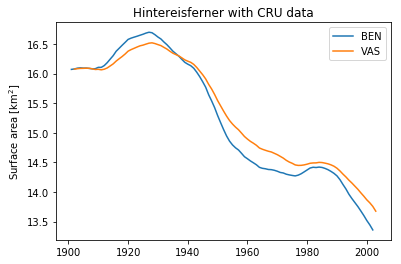

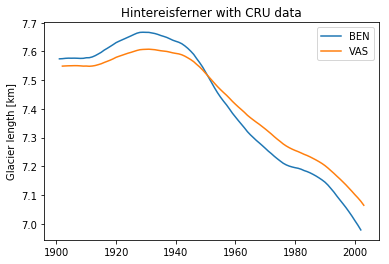

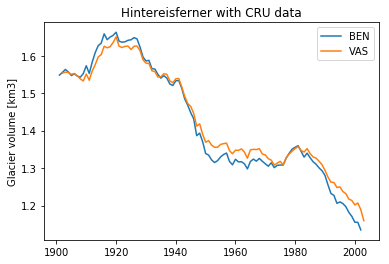

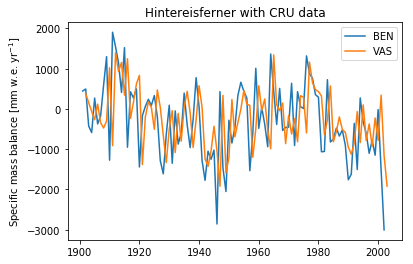

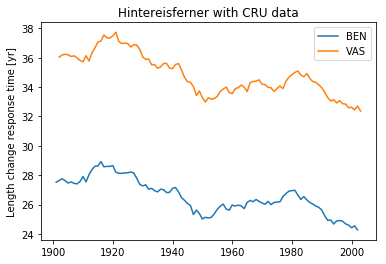

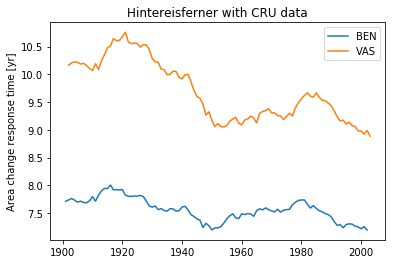

In [8]:
# prepare parameters for plotting
mat_years = mat_file['years'][0, :102]
vas_years = diag_ds.hydro_year
mat_params = ['A_pre', 'L_pre', 'V_pre', 'mb_modeled_pre', 'tau_L', 'tau_A']
vas_params = ['area_m2', 'length_m', 'volume_m3', 'spec_mb', 'tau_l', 'tau_a']
labels = ['Surface area [km$^2$]', 'Glacier length [km]',
          'Glacier volume [km3]', 'Specific mass balance [mm w.e. yr$^{-1}$]',
          'Length change response time [yr]', 'Area change response time [yr]']
factors = [1e6, 1e3, 1e9, 1, 1, 1]
# plot all parameters
for mat, vas, label, f in zip(mat_params, vas_params, labels, factors):
    plt.figure()
    plt.plot(mat_years, mat_file[mat][0, :102], label='BEN')
    plt.plot(vas_years, diag_ds[vas] / f, label='VAS')
    plt.legend()
    plt.xlabel('')
    plt.ylabel(label)
    plt.title('Hintereisferner with CRU data')

In [26]:
diag_ds_full = diag_ds.copy()

In [30]:
diag_ds = diag_ds_full.sel(time=slice(1902,1912))

In [28]:
import matplotlib.pyplot as plt

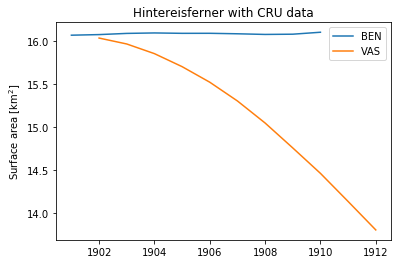

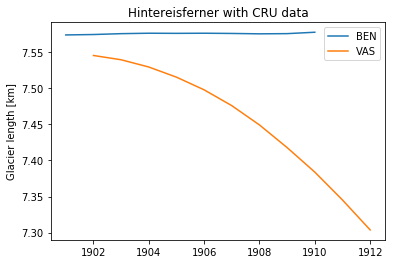

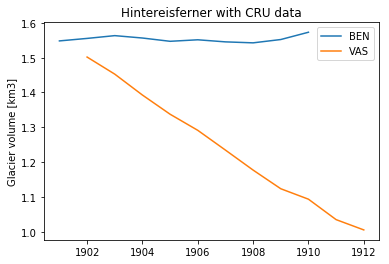

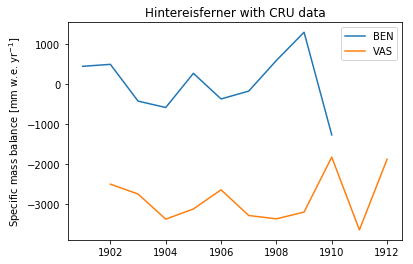

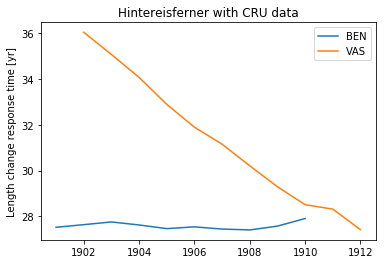

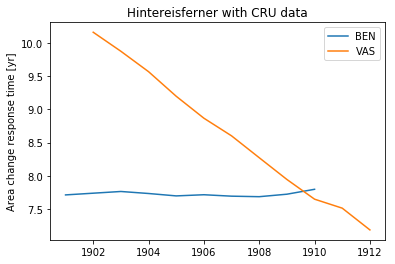

In [31]:
# prepare parameters for plotting
mat_years = mat_file['years'][0, :10]
vas_years = diag_ds.hydro_year
mat_params = ['A_pre', 'L_pre', 'V_pre', 'mb_modeled_pre', 'tau_L', 'tau_A']
vas_params = ['area_m2', 'length_m', 'volume_m3', 'spec_mb', 'tau_l', 'tau_a']
labels = ['Surface area [km$^2$]', 'Glacier length [km]',
          'Glacier volume [km3]', 'Specific mass balance [mm w.e. yr$^{-1}$]',
          'Length change response time [yr]', 'Area change response time [yr]']
factors = [1e6, 1e3, 1e9, 1, 1, 1]
# plot all parameters
for mat, vas, label, f in zip(mat_params, vas_params, labels, factors):
    plt.figure()
    plt.plot(mat_years, mat_file[mat][0, :10], label='BEN')
    plt.plot(vas_years, diag_ds[vas] / f, label='VAS')
    plt.legend()
    plt.xlabel('')
    plt.ylabel(label)
    plt.title('Hintereisferner with CRU data')

In [ ]:
# import externals libs
import os
import shutil
import scipy.io
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt

# import the needed OGGM modules
import oggm
from oggm import cfg, utils
from oggm.utils import get_demo_file
from oggm.tests.funcs import get_test_dir
from oggm.core import gis, climate, centerlines, vascaling

In [ ]:
# create test directory
testdir = os.path.join(get_test_dir(), 'tmp_ben')
if not os.path.exists(testdir):
    os.makedirs(testdir)
shutil.rmtree(testdir)
os.makedirs(testdir)

In [ ]:
# load default parameter file
cfg.initialize()
# set path to working directory
cfg.PATHS['working_dir'] = testdir
# load and set path to intersects
path = utils.get_rgi_intersects_region_file('11', version='6')
cfg.set_intersects_db(path)

# change some default parameters
cfg.PARAMS['border'] = 50
cfg.PARAMS['baseline_climate'] = 'CRU'
cfg.PARAMS['use_multiprocessing'] = True


In [ ]:
utils.get_rgi_glacier_entities(['RGI60-11.00897'])

In [ ]:
# get RGI entity
entity = utils.get_rgi_glacier_entities(['RGI60-11.00897']).iloc[0]
# initialize the GlacierDirectory
gdir = oggm.GlacierDirectory(entity, base_dir=testdir)
# define the local grid and glacier mask
gis.define_glacier_region(gdir, entity=entity)
gis.glacier_masks(gdir)

In [ ]:
# process the given climate file
climate.process_cru_data(gdir)

# run center line preprocessing tasks
centerlines.compute_centerlines(gdir)
centerlines.initialize_flowlines(gdir)
centerlines.catchment_area(gdir)
centerlines.catchment_intersections(gdir)
centerlines.catchment_width_geom(gdir)
centerlines.catchment_width_correction(gdir)

In [ ]:
# --------------------
#  MASS BALANCE TASKS
# --------------------

# compute local t* and the corresponding mu*
vascaling.local_t_star(gdir)

# instance the mass balance models
mbmod = vascaling.VAScalingMassBalance(gdir)

In [ ]:
# ----------------
#  DYNAMICAL PART
# ----------------
# get reference area
a0 = gdir.rgi_area_m2
# get reference year
y0 = gdir.read_pickle('climate_info')['baseline_hydro_yr_0']
# get min and max glacier surface elevation
h0, h1 = vascaling.get_min_max_elevation(gdir)

ben_model = vascaling.VAScalingModel(year_0=y0, area_m2_0=a0,
                                     min_hgt=h0, max_hgt=h1,
                                     mb_model=mbmod)

In [ ]:
ben_model.create_start_glacier(9.793874999999998*1e6, year_start=1902)
diag_ds = ben_model.run_until_and_store(2003)

In [ ]:
diag_ds.area_m2.plot()

In [ ]:
# read matlab data
mat = scipy.io.loadmat('/Users/oberrauch/work/master/data/mat_files/full_workspace.mat')

# get needed parameters from *.mat file
years = np.array([yr for yr in mat['cru_years']])
years = years[years <= 2003]
a_pre = np.array([a for a in mat['A_pre']])[0]
a_ben = a_pre.copy()

In [ ]:
diag_ds

In [ ]:
# plot both modeled area changes
plt.plot(years, a_ben, label='BEN')
plt.plot(diag_ds.hydro_year, diag_ds.area_m2/1e6, label='VAS')
plt.legend()
plt.xlabel('')
plt.ylabel('Surface area [km$^2$]')
plt.title('Hintereisferner with CRU data, A$_0$ = {:.2f} km$^2$'.format(a_ben[0]))

In [ ]:
# read matlab data
mat = scipy.io.loadmat('/Users/oberrauch/work/master/data/mat_files/A_pre_best_guess.mat')
years = np.arange(1901, 2004)
# get area
a_best_fit = np.array([a for a in mat['A_pre']])[0]
a_ben = a_best_fit.copy()

plt.plot(years, a_best_fit, label='BEN')
plt.plot(diag_ds.hydro_year, diag_ds.area_m2/1e6, label='VAS')
plt.legend()
plt.xlabel('')
plt.ylabel('Surface area [km$^2$]')
plt.title('Hintereisferner with CRU data, A$_0$ = {:.2f} km$^2$'.format(a_ben[0]))

In [ ]:
# read matlab data
mat = scipy.io.loadmat('/Users/oberrauch/work/master/data/mat_files/time_scales.mat')
# get time scales
tau_l = np.array([a for a in mat['tau_L']])[0]
tau_a = np.array([a for a in mat['tau_A']])[0]

In [ ]:
plt.plot(years[1:], tau_l, label='BEN')
plt.plot(diag_ds.hydro_year, diag_ds.tau_l, label='VAS')
plt.legend()

In [ ]:
diag_ds.tau_a

In [ ]:
plt.plot(years[1:], tau_a, label='BEN')
plt.plot(diag_ds.hydro_year, diag_ds.tau_a, label='VAS')
plt.legend()

In [ ]:
ben_model.create_start_glacier(16.072e6, year_start=1902)
print(ben_model)

In [ ]:
i = 0
print('Iteration', i, '\n-----------------')
print('Area {:.3f} km2'.format(diag_ds.area_m2[i].values/1e6))
print('Volume {:.3f} km3'.format(diag_ds.volume_m3[i].values/1e9))
print('Length {:.3f} km'.format(diag_ds.length_m[i].values/1e3))

In [ ]:
diag_ds

In [ ]:
df = diag_ds.to_dataframe()
df = pd.concat([df['length_m'], df['area_m2'], df['volume_m3']], axis=1)

In [ ]:
store = False
if store:
    # define path and file names
    folder = '/Users/oberrauch/work/master/data/'
    suffix = '_test_start_area'
    names = ['length', 'area', 'volume']
    # combine glacier geometries into DataFrame
    import numpy as np
    import pandas as pd
    df = [diag_ds['hydro_year', 'length_m'], diag_ds['area_m2'], diag_ds['volume_m3']]
    df = pd.concat([df_.to_dataframe() for df_ in df])
    df.to_csv(folder+'run'+suffix+'.csv')

plot = True
if plot:
    unit = 'km'
    unit_factor = 1e3
    # define path and file names
    folder = '/Users/oberrauch/work/master/plots/'
    suffix = '_test_start_area'

    plt.figure()
    plt.plot(diag_ds['area_m2']/unit_factor**2)
    plt.title('Hintereis Ferner - Area')
    plt.ylabel('Area [{}$^2$]'.format(unit))
    plt.savefig(folder+'area'+suffix+'.png', bbox_inches='tight')

    plt.figure()
    plt.plot(diag_ds['volume_m3']/unit_factor**3)
    plt.title('Hintereis Ferner - Volume')
    plt.ylabel('Volume [{}$^3$]'.format(unit))
    plt.savefig(folder+'volume'+suffix+'.png', bbox_inches='tight')

    plt.figure()
    plt.plot(diag_ds['length_m']/unit_factor)
    plt.title('Hintereis Ferner - Length')
    plt.ylabel('Length [{}]'.format(unit))
    plt.savefig(folder+'length'+suffix+'.png', bbox_inches='tight')

    plt.show()

In [ ]:
df.iloc[-1]